# Generalization Full Scale Runner - Ready - 14/12/2022

### Generalization estimates how well the process model describes the (unknown) system, and not only the event log. If all parts of the process model are frequently used, the process model is likely to be generic. However, if some parts of the process model are rarely used, chances are high that the system actually allows for more behavior. Therefore we base the generalization measure on how often parts of the process model have been used while replaying the event log.

### To Generate a Range of Generalization values between two Numbers

#### Importing Libraries 

In [1]:
import os
import configparser
from datetime import date
import pandas as pd
import re
import graphviz
import math
import seaborn as sns
import collections
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
#sns.set(style="darkgrid")

from tqdm import tqdm
from tqdm import trange


#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

#### Profit Intialization

In [2]:
PATH = 'C:\\Users\\ashis\\Python Notebooks\\ProFIT'# path to ProFIT directory
config = configparser.ConfigParser()
config.add_section("packageLocation")
config.set("packageLocation", "workingDir", PATH)
config.set("packageLocation", "packageDir", PATH+'\\profit')


import sys
sys.path.append(config["packageLocation"]["workingDir"])
sys.path.append(config["packageLocation"]["packageDir"])


from profit import ProcessMap
pm = ProcessMap()

# Generalization Class

In [3]:
class Genset:
    def __init__(self, IN_DATA, Act_Rate, Path_Rate):
        self.IN_DATA = IN_DATA
        self.Act_Rate = Act_Rate
        self.Path_Rate = Path_Rate
        
    def Filter(self,net):
        temp = str(net)
        temp = temp.lower()
        temp = re.sub("\d",'', temp)
        temp = re.sub('node',' ', temp)
        temp = re.sub('\(', "", temp)
        temp = re.sub('\)', "", temp)
        temp = re.sub('\[', "", temp)
        temp = re.sub('\]', "", temp)
        temp = re.sub('\{', "", temp)
        temp = re.sub('\}', "", temp)
        temp = re.sub('connections',' ', temp)
        temp = re.sub(' ','', temp)
        
        temp = re.sub('\:',' ', temp)
        temp = re.sub('\,',' ', temp)
        temp = re.sub('\'',' ', temp)
        temp = re.sub('\.',' ', temp)
        temp = re.sub(' +', ' ', temp)
        temp = re.sub('"', ' ', temp)
        return temp
    
    def Final(self, net):
        temp = str(net)
        temp = temp.lower()
        temp = re.sub("\d",'', temp)
        temp = re.sub('node',' ', temp)
        temp = re.sub('\(', "", temp)
        temp = re.sub('\)', "", temp)
        temp = re.sub('\[', "", temp)
        temp = re.sub('\]', "", temp)
        temp = re.sub('\{', "", temp)
        temp = re.sub('\}', "", temp)
        temp = re.sub('connections',' ', temp)
        temp = re.sub(' ','', temp)
        
        temp = re.sub('\:',' ', temp)
        temp = re.sub('\,',' ', temp)
        temp = re.sub('\'',' ', temp)
        temp = re.sub('\.',' ', temp)
        temp = re.sub(' +', ' ', temp)
        temp = re.sub('"', ' ', temp)
        HT = pd.DataFrame([x.split(' ') for x in temp.split('\n')])
        HT = HT.transpose()
        HT = HT.drop([0]).reset_index(drop = True)
        HT.columns = ['Task']
        HT= HT.drop(index=HT.index[-1])
        HT = HT.drop_duplicates(ignore_index=True)
        HT = HT.sort_values("Task").reset_index(drop = True)
        #print(HT)
    
        return HT 
    
    
    
    def Activites(RAW): 
    
        A = (RAW.IN_DATA).copy()
        A.drop("case_id", inplace=True, axis = 1)
        A.drop("timestamp", inplace=True, axis = 1)
    
        # To be enabled when there are additional fields present in the RAW Event log 
        #A.drop("case_id", inplace=True, axis = 1)
        #A.drop("timestamp", inplace=True, axis = 1)
        
        
        A = A['task'].value_counts() # The Name of the field which contains the names of the Task is supposed to be Subsituted incase it isnt the same 
        
        B = A.to_frame(name="Freq")
        
        B = B.rename_axis("Task").reset_index() # The Name "Task" here should remain the same as it is later utilized for merging of Dataframes
        
        
        # The Function "Filter" is used to make the Activity Labels uniform for both the Process Model & the Initial Event log
        for i in range(len(B)):
            temp_str_var = Obj.Filter(B.iloc[i,0])
            B.iloc[i,0] = temp_str_var
            
        return (B)
    
    def MapGen(Log_DATA):
    
    
        pm.set_log(data = Log_DATA.IN_DATA)
    
    
        # Have to change "Optimize" State when using Manual Path & Activity Rates
        pm.set_params(optimize=False,aggregate=False) # Optimize = TRUE/FALSE # Agg_type = inner/outer
    
    
        # Will be activated only when "OPTIMIZE" from above is changed to "False"
        pm.set_rates(activity_rate = Log_DATA.Act_Rate, path_rate = Log_DATA.Path_Rate) # Rates = Activity & Path rate only 
    
        # Logic on this (or in % , where 100% means complete utilization & 0% Vice Versa) 
        # Activity Rate = The precision/clarity of the model/graph being produced (i.e. when at 100 = all events are displayed, when at 5-10 low number of events with the most highest weightage are displayed)
        # Path rate = the regulation of paths (i.e. aggregation of path in %)0 = high aggregation of path, 100 % super detailed paths to every case/task
    
        pm.update() # Updates settings
    
        # pm.render() # Renders the Final Process Model
    
        print(pm.get_rates())
    
        net = str(pm.get_graph())

        Node_Extract = Obj.Final(net)
    
        Node_Extract = Node_Extract.rename(columns = {"concept:name":"Task"})  # Rename the input column name so that it can be relabeled to original
    
        
        
        
        
        MergedDF = pd.merge(Node_Extract, LOG, how='inner', on=None, left_on=None, right_on=None,
             left_index=False, right_index=False, sort=True,
             suffixes=('_x', '_y'), copy=True, indicator=False,
             validate=None)
    
        for i in range(len(MergedDF)):
            TEMP = pow(math.sqrt(MergedDF.iloc[i,1]),-1)
            MergedDF.iloc[i,1] = TEMP
        
        Gen = 1 - (MergedDF['Freq'].sum()/len(MergedDF))
    
        return Gen

---------

## Data Input

In [2]:
df = pd.read_csv("remote_monitoring_eng.csv") #
df

,case_id,task,timestamp
0,4082,New med program operator,2018-01-10 00:00:03
1,4082,Red zone operator,2018-01-10 22:09:21
2,4173,New med program operator,2018-01-12 00:00:04
3,4176,New med program operator,2018-01-12 00:00:04
4,4082,Red zone doctor FD,2018-01-12 02:44:28
...,...,...,...
35606,9155,Notification operator,2018-12-31 09:03:14
35607,9362,Notification operator,2018-12-31 09:03:16
35608,9758,Notification operator,2018-12-31 09:03:23
35609,9938,Notification operator,2018-12-31 09:03:26


In [5]:
df["case_id"]

0         4082
1         4082
2         4173
3         4176
4         4082
         ...  
35606     9155
35607     9362
35608     9758
35609     9938
35610    10240
Name: case_id, Length: 35611, dtype: int64

In [5]:
df1 = df[df['task'] != 'New med program operator']
df1 = df1.reset_index(drop = True)

--------

# Actuation

---------------

### Generalization Calculation - Activity Rate - varied / Path Rate - Constant

In [1]:
Act = []
#Path = []
Gen = []

PATH_THRES = [5,20,40,60,80,100]


for j in trange(len(PATH_THRES)):
    
    # Reinitialization
    
    Act = []
    #Path = []
    Gen = []
    
    for i in trange(0,101,1):
        
        print("\n\n Rate of Activity = ", i," \n Rate of Path = ", PATH_THRES[j])
        Obj = Genset(df1, i, PATH_THRES[j]) # Creating Object for the Class # ACTIVITY (0-100), PATH (5,20,40,60,80,100) Const
    
        LOG = Obj.Activites() # Initiating the first Function
        Gen_Final = Obj.MapGen() # Final Gen Value
    
        #print("\n\n The Generalization Rating for this Model = ", Gen_Final)
        #print("\n                         Or in Percentile = ", Gen_Final*100," % \n")
    
        Act.append(i)
        #Path.append(i)
        Gen.append(Gen_Final*100)
        print("Generalization = ", Gen_Final*100)
        print("----------------------------------------------------NEXT-------------------------------------------------")
    print("----------------------------------------------------DONE-------------------------------------------------")
    
    if j == 0:
        res_af0 = pd.DataFrame({"Path_Rate":Act,"Generalization":Gen})
        #res_af1
        
    elif j == 1:
        res_af1 = pd.DataFrame({"Path_Rate":Act,"Generalization":Gen})
        #res_af1
    
    elif j == 2:
        res_af2 = pd.DataFrame({"Path_Rate":Act,"Generalization":Gen})
    
    elif j == 3:
        res_af3 = pd.DataFrame({"Path_Rate":Act,"Generalization":Gen})
    
    elif j == 4:
        res_af4 = pd.DataFrame({"Path_Rate":Act,"Generalization":Gen})
    
    elif j == 5:
        res_af5 = pd.DataFrame({"Path_Rate":Act,"Generalization":Gen})
    
    
ACT_FULL = res_af0.copy()
ACT_FULL = ACT_FULL.merge(res_af1, on='Path_Rate', how='right')
ACT_FULL = ACT_FULL.merge(res_af2, on='Path_Rate', how='right')
ACT_FULL = ACT_FULL.merge(res_af3, on='Path_Rate', how='right')
ACT_FULL = ACT_FULL.merge(res_af4, on='Path_Rate', how='right')
ACT_FULL = ACT_FULL.merge(res_af5, on='Path_Rate', how='right')

ACT_FULL.columns = ['Activity_Rate', 'Path = 5', 'Path = 20' ,'Path = 40', 'Path = 60','Path = 80','Path = 100']

ACT_FULL
        

NameError: name 'trange' is not defined

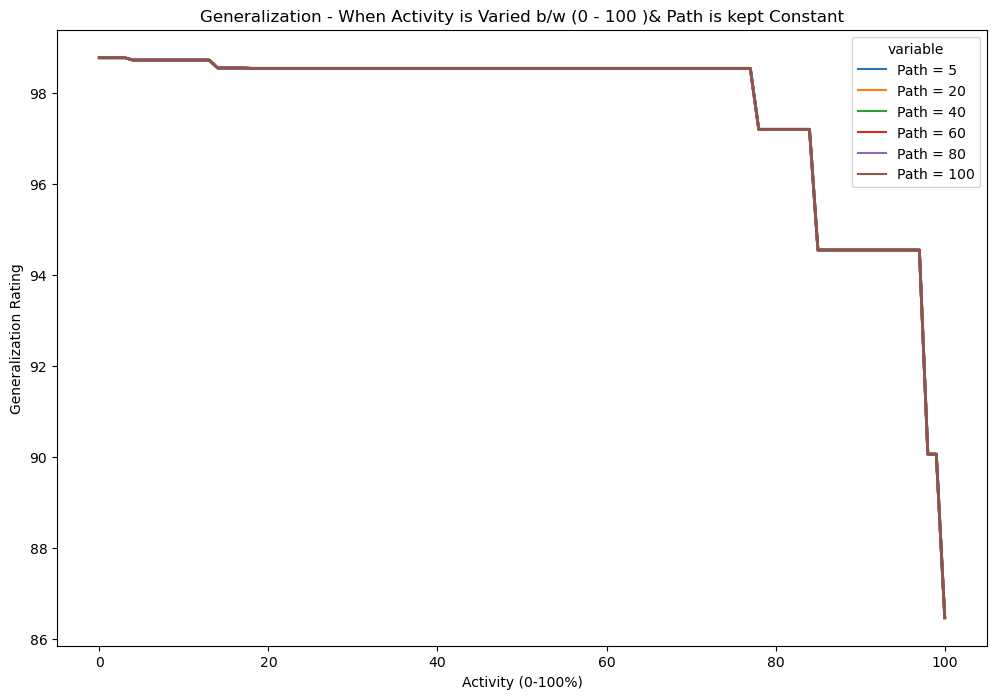

In [70]:
figure(figsize=(12, 8), dpi=100)
sns.lineplot(x='Activity_Rate', y='value', hue='variable', data=pd.melt(ACT_FULL, ['Activity_Rate']), lw = 2)
plt.xlabel("Activity (0-100%)")
plt.ylabel("Generalization Rating")
plt.title("Generalization - When Activity is Varied b/w (0 - 100 )& Path is kept Constant")
plt.show()

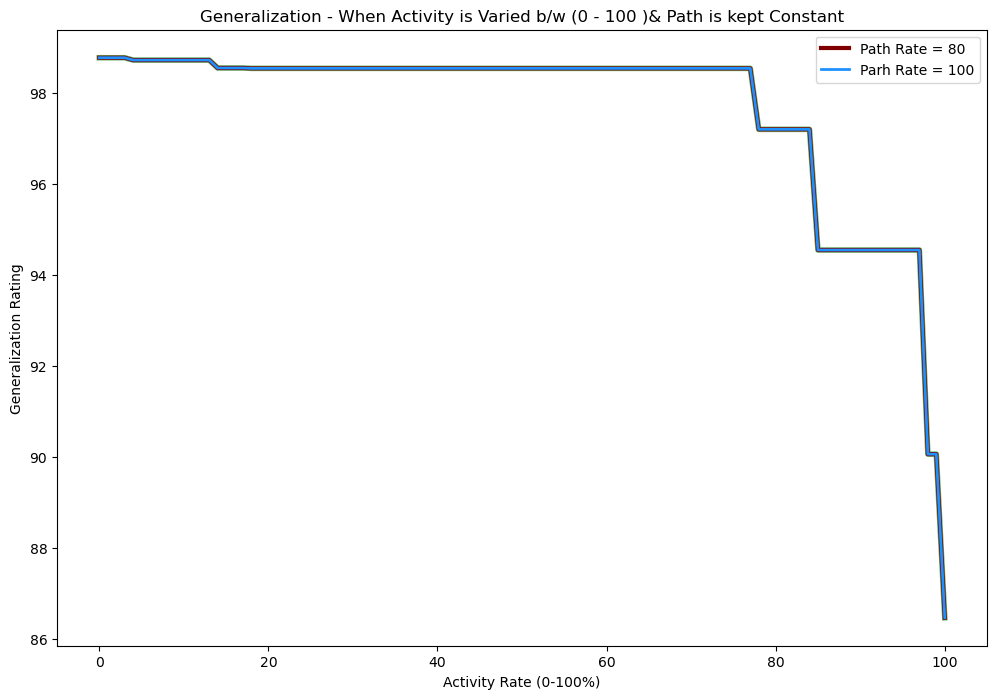

In [71]:
figure(figsize=(12, 8), dpi=100)
sns.lineplot(x='Path_Rate', y='Generalization', data=res_af0, lw = 2, color = 'blue')
sns.lineplot(x='Path_Rate', y='Generalization', data=res_af1, lw = 2, color = 'yellow')
sns.lineplot(x='Path_Rate', y='Generalization', data=res_af2, lw = 4, alpha = 0.6, color = 'green')
sns.lineplot(x='Path_Rate', y='Generalization', data=res_af3, lw = 2, alpha = 0.6, color = 'purple')
sns.lineplot(x='Path_Rate', y='Generalization', data=res_af4, lw = 3, label = "Path Rate = 80", color = 'maroon')
sns.lineplot(x='Path_Rate', y='Generalization', data=res_af5, lw = 2, label = "Parh Rate = 100", color = 'dodgerblue')
#sns.lineplot(x='Activity_Rate', y='value', hue='variable', data=pd.melt(ACT_FULL, re['Activity_Rate']), lw = 2)
plt.xlabel("Activity Rate (0-100%)")
plt.ylabel("Generalization Rating")
plt.title("Generalization - When Activity is Varied b/w (0 - 100 )& Path is kept Constant")
plt.show()

In [ ]:
ACT_FULL.to_csv("Sample_5_Generalization_ACT.csv")

In [ ]:
figure(figsize=(12, 8), dpi=100)
sns.lineplot(x='Activity_Rate', y='value', hue='variable', data=pd.melt(ACT_FULL, ['Activity_Rate']), lw = 2)
plt.xlabel("Activity (0-100%)")
plt.ylabel("Fitness Rating")
plt.title("Fitness - When Activity is Varied b/w (0 - 100 )& Path is kept Constant")
plt.show()

----------------

### Generalization Calculation - Activity Rate - Constant / Path Rate - Varied


In [73]:
#Act = []
Path = []
Gen = []

ACT_THRES = [5,20,40,60,80,100]


for j in trange(len(ACT_THRES)):
    
    # Reinitialization
    
    #Act = []
    Path = []
    Gen = []
    
    for i in trange(0,101,1):
        
        print("\n\n Rate of Activity = ", ACT_THRES[j]," \n Rate of Path = ", i)
        Obj = Genset(df1, ACT_THRES[j], i) # Creating Object for the Class # ACTIVITY (0-100), PATH (5,20,40,60,80,100) Const
    
        LOG = Obj.Activites() # Initiating the first Function
        Gen_Final = Obj.MapGen() # Final Gen Value
    
        #print("\n\n The Generalization Rating for this Model = ", Gen_Final)
        #print("\n                         Or in Percentile = ", Gen_Final*100," % \n")
    
        #Act.append(i)
        Path.append(i)
        Gen.append(Gen_Final*100)
        print("Generalization = ", Gen_Final*100)
        print("----------------------------------------------------NEXT-------------------------------------------------")
        
    print("----------------------------------------------------DONE-------------------------------------------------")
    
    if j == 0:
        res_df0 = pd.DataFrame({"Activity_rate":Path,"Generalization":Gen})
        #res_df1
        
    elif j == 1:
        res_df1 = pd.DataFrame({"Activity_rate":Path,"Generalization":Gen})
        #res_df1
    
    elif j == 2:
        res_df2 = pd.DataFrame({"Activity_rate":Path,"Generalization":Gen})
    
    elif j == 3:
        res_df3 = pd.DataFrame({"Activity_rate":Path,"Generalization":Gen})
    
    elif j == 4:
        res_df4 = pd.DataFrame({"Activity_rate":Path,"Generalization":Gen})
    
    elif j == 5:
        res_df5 = pd.DataFrame({"Activity_rate":Path,"Generalization":Gen})
    
    
PATH_FULL = res_df0.copy()
PATH_FULL = PATH_FULL.merge(res_df1, on='Activity_rate', how='right')
PATH_FULL = PATH_FULL.merge(res_df2, on='Activity_rate', how='right')
PATH_FULL = PATH_FULL.merge(res_df3, on='Activity_rate', how='right')
PATH_FULL = PATH_FULL.merge(res_df4, on='Activity_rate', how='right')
PATH_FULL = PATH_FULL.merge(res_df5, on='Activity_rate', how='right')

PATH_FULL.columns = ['Path_Rate', 'Activity = 5', 'Activity = 20' ,'Activity = 40', 'Activity = 60','Activity = 80','Activity = 100']

PATH_FULL
        



 Rate of Activity =  0  
 Rate of Path =  5
{'activities': 5, 'paths': 0}


 Rate of Activity =  1  
 Rate of Path =  5
{'activities': 5, 'paths': 1}


 Rate of Activity =  2  
 Rate of Path =  5
{'activities': 5, 'paths': 2}


 Rate of Activity =  3  
 Rate of Path =  5
{'activities': 5, 'paths': 3}


 Rate of Activity =  4  
 Rate of Path =  5
{'activities': 5, 'paths': 4}


 Rate of Activity =  5  
 Rate of Path =  5
{'activities': 5, 'paths': 5}


 Rate of Activity =  6  
 Rate of Path =  5
{'activities': 5, 'paths': 6}


 Rate of Activity =  7  
 Rate of Path =  5
{'activities': 5, 'paths': 7}


 Rate of Activity =  8  
 Rate of Path =  5
{'activities': 5, 'paths': 8}


 Rate of Activity =  9  
 Rate of Path =  5
{'activities': 5, 'paths': 9}


 Rate of Activity =  10  
 Rate of Path =  5
{'activities': 5, 'paths': 10}


 Rate of Activity =  11  
 Rate of Path =  5
{'activities': 5, 'paths': 11}


 Rate of Activity =  12  
 Rate of Path =  5
{'activities': 5, 'paths': 12}


 Rat

{'activities': 20, 'paths': 4}


 Rate of Activity =  5  
 Rate of Path =  20
{'activities': 20, 'paths': 5}


 Rate of Activity =  6  
 Rate of Path =  20
{'activities': 20, 'paths': 6}


 Rate of Activity =  7  
 Rate of Path =  20
{'activities': 20, 'paths': 7}


 Rate of Activity =  8  
 Rate of Path =  20
{'activities': 20, 'paths': 8}


 Rate of Activity =  9  
 Rate of Path =  20
{'activities': 20, 'paths': 9}


 Rate of Activity =  10  
 Rate of Path =  20
{'activities': 20, 'paths': 10}


 Rate of Activity =  11  
 Rate of Path =  20
{'activities': 20, 'paths': 11}


 Rate of Activity =  12  
 Rate of Path =  20
{'activities': 20, 'paths': 12}


 Rate of Activity =  13  
 Rate of Path =  20
{'activities': 20, 'paths': 13}


 Rate of Activity =  14  
 Rate of Path =  20
{'activities': 20, 'paths': 14}


 Rate of Activity =  15  
 Rate of Path =  20
{'activities': 20, 'paths': 15}


 Rate of Activity =  16  
 Rate of Path =  20
{'activities': 20, 'paths': 16}


 Rate of Activity

{'activities': 40, 'paths': 8}


 Rate of Activity =  9  
 Rate of Path =  40
{'activities': 40, 'paths': 9}


 Rate of Activity =  10  
 Rate of Path =  40
{'activities': 40, 'paths': 10}


 Rate of Activity =  11  
 Rate of Path =  40
{'activities': 40, 'paths': 11}


 Rate of Activity =  12  
 Rate of Path =  40
{'activities': 40, 'paths': 12}


 Rate of Activity =  13  
 Rate of Path =  40
{'activities': 40, 'paths': 13}


 Rate of Activity =  14  
 Rate of Path =  40
{'activities': 40, 'paths': 14}


 Rate of Activity =  15  
 Rate of Path =  40
{'activities': 40, 'paths': 15}


 Rate of Activity =  16  
 Rate of Path =  40
{'activities': 40, 'paths': 16}


 Rate of Activity =  17  
 Rate of Path =  40
{'activities': 40, 'paths': 17}


 Rate of Activity =  18  
 Rate of Path =  40
{'activities': 40, 'paths': 18}


 Rate of Activity =  19  
 Rate of Path =  40
{'activities': 40, 'paths': 19}


 Rate of Activity =  20  
 Rate of Path =  40
{'activities': 40, 'paths': 20}


 Rate of 

{'activities': 60, 'paths': 12}


 Rate of Activity =  13  
 Rate of Path =  60
{'activities': 60, 'paths': 13}


 Rate of Activity =  14  
 Rate of Path =  60
{'activities': 60, 'paths': 14}


 Rate of Activity =  15  
 Rate of Path =  60
{'activities': 60, 'paths': 15}


 Rate of Activity =  16  
 Rate of Path =  60
{'activities': 60, 'paths': 16}


 Rate of Activity =  17  
 Rate of Path =  60
{'activities': 60, 'paths': 17}


 Rate of Activity =  18  
 Rate of Path =  60
{'activities': 60, 'paths': 18}


 Rate of Activity =  19  
 Rate of Path =  60
{'activities': 60, 'paths': 19}


 Rate of Activity =  20  
 Rate of Path =  60
{'activities': 60, 'paths': 20}


 Rate of Activity =  21  
 Rate of Path =  60
{'activities': 60, 'paths': 21}


 Rate of Activity =  22  
 Rate of Path =  60
{'activities': 60, 'paths': 22}


 Rate of Activity =  23  
 Rate of Path =  60
{'activities': 60, 'paths': 23}


 Rate of Activity =  24  
 Rate of Path =  60
{'activities': 60, 'paths': 24}


 Rate 



 Rate of Activity =  16  
 Rate of Path =  80
{'activities': 80, 'paths': 16}


 Rate of Activity =  17  
 Rate of Path =  80
{'activities': 80, 'paths': 17}


 Rate of Activity =  18  
 Rate of Path =  80
{'activities': 80, 'paths': 18}


 Rate of Activity =  19  
 Rate of Path =  80
{'activities': 80, 'paths': 19}


 Rate of Activity =  20  
 Rate of Path =  80
{'activities': 80, 'paths': 20}


 Rate of Activity =  21  
 Rate of Path =  80
{'activities': 80, 'paths': 21}


 Rate of Activity =  22  
 Rate of Path =  80
{'activities': 80, 'paths': 22}


 Rate of Activity =  23  
 Rate of Path =  80
{'activities': 80, 'paths': 23}


 Rate of Activity =  24  
 Rate of Path =  80
{'activities': 80, 'paths': 24}


 Rate of Activity =  25  
 Rate of Path =  80
{'activities': 80, 'paths': 25}


 Rate of Activity =  26  
 Rate of Path =  80
{'activities': 80, 'paths': 26}


 Rate of Activity =  27  
 Rate of Path =  80
{'activities': 80, 'paths': 27}


 Rate of Activity =  28  
 Rate of Pat



 Rate of Activity =  18  
 Rate of Path =  100
{'activities': 100, 'paths': 18}


 Rate of Activity =  19  
 Rate of Path =  100
{'activities': 100, 'paths': 19}


 Rate of Activity =  20  
 Rate of Path =  100
{'activities': 100, 'paths': 20}


 Rate of Activity =  21  
 Rate of Path =  100
{'activities': 100, 'paths': 21}


 Rate of Activity =  22  
 Rate of Path =  100
{'activities': 100, 'paths': 22}


 Rate of Activity =  23  
 Rate of Path =  100
{'activities': 100, 'paths': 23}


 Rate of Activity =  24  
 Rate of Path =  100
{'activities': 100, 'paths': 24}


 Rate of Activity =  25  
 Rate of Path =  100
{'activities': 100, 'paths': 25}


 Rate of Activity =  26  
 Rate of Path =  100
{'activities': 100, 'paths': 26}


 Rate of Activity =  27  
 Rate of Path =  100
{'activities': 100, 'paths': 27}


 Rate of Activity =  28  
 Rate of Path =  100
{'activities': 100, 'paths': 28}


 Rate of Activity =  29  
 Rate of Path =  100
{'activities': 100, 'paths': 29}


 Rate of Activ

C:\Users\ashis\AppData\Local\Temp\ipykernel_24868\3896335883.py:57: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Generalization_x'} in the result is deprecated and will raise a MergeError in a future version.
  PATH_FULL = PATH_FULL.merge(res_df3, on='Activity_rate', how='right')
C:\Users\ashis\AppData\Local\Temp\ipykernel_24868\3896335883.py:59: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Generalization_x'} in the result is deprecated and will raise a MergeError in a future version.
  PATH_FULL = PATH_FULL.merge(res_df5, on='Activity_rate', how='right')


,Path_Rate,Activity = 5,Activity = 20,Activity = 40,Activity = 60,Activity = 80,Activity = 100
0,0,98.726643,98.544244,98.544244,98.544244,97.202706,86.458586
1,1,98.726643,98.544244,98.544244,98.544244,97.202706,86.458586
2,2,98.726643,98.544244,98.544244,98.544244,97.202706,86.458586
3,3,98.726643,98.544244,98.544244,98.544244,97.202706,86.458586
4,4,98.726643,98.544244,98.544244,98.544244,97.202706,86.458586
...,...,...,...,...,...,...,...
96,96,98.726643,98.544244,98.544244,98.544244,97.202706,86.458586
97,97,98.726643,98.544244,98.544244,98.544244,97.202706,86.458586
98,98,98.726643,98.544244,98.544244,98.544244,97.202706,86.458586
99,99,98.726643,98.544244,98.544244,98.544244,97.202706,86.458586


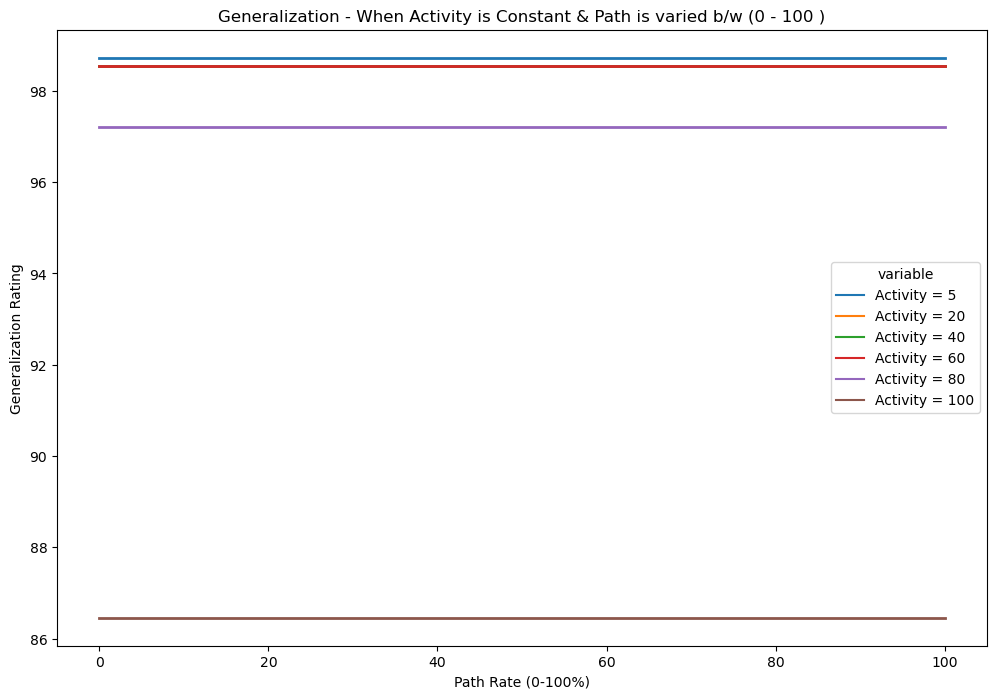

In [75]:
figure(figsize=(12, 8), dpi=100)
sns.lineplot(x='Path_Rate', y='value', hue='variable', data=pd.melt(PATH_FULL, ['Path_Rate']), lw = 2)
plt.xlabel("Path Rate (0-100%)")
plt.ylabel("Generalization Rating")
plt.title("Generalization - When Activity is Constant & Path is varied b/w (0 - 100 )")
plt.show()

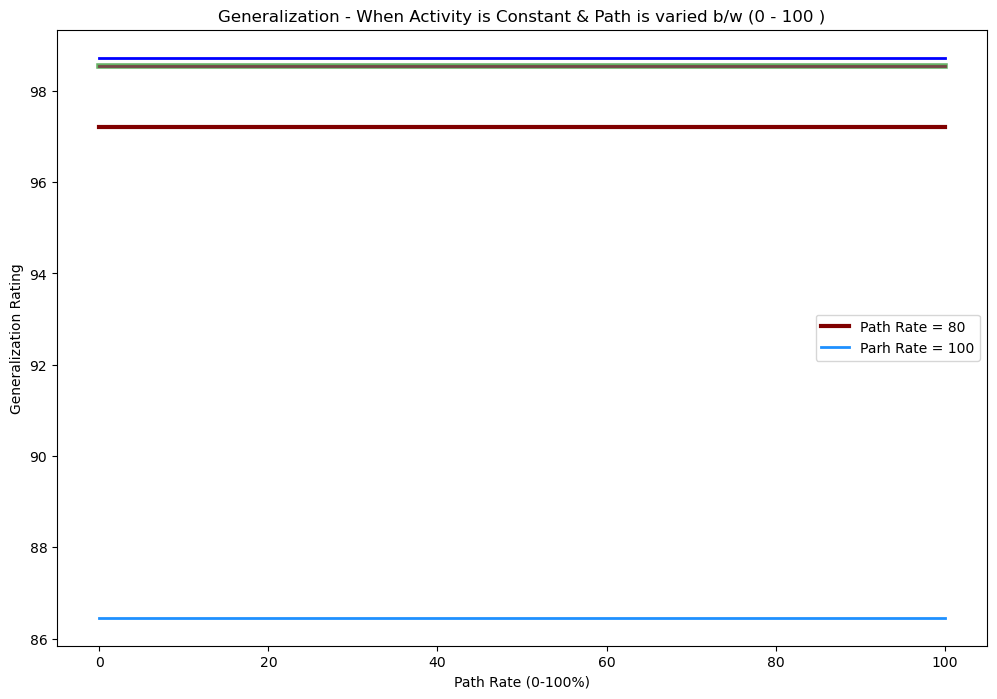

In [76]:
figure(figsize=(12, 8), dpi=100)
sns.lineplot(x='Activity_rate', y='Generalization', data=res_df0, lw = 2, color = 'blue')
sns.lineplot(x='Activity_rate', y='Generalization', data=res_df1, lw = 2, color = 'yellow')
sns.lineplot(x='Activity_rate', y='Generalization', data=res_df2, lw = 4, alpha = 0.6, color = 'green')
sns.lineplot(x='Activity_rate', y='Generalization', data=res_df3, lw = 2, alpha = 0.6, color = 'purple')
sns.lineplot(x='Activity_rate', y='Generalization', data=res_df4, lw = 3, label = "Path Rate = 80", color = 'maroon')
sns.lineplot(x='Activity_rate', y='Generalization', data=res_df5, lw = 2, label = "Parh Rate = 100", color = 'dodgerblue')
#sns.lineplot(x='Activity_Rate', y='value', hue='variable', data=pd.melt(ACT_FULL, re['Activity_Rate']), lw = 2)
plt.xlabel("Path Rate (0-100%)")
plt.ylabel("Generalization Rating")
plt.title("Generalization - When Activity is Constant & Path is varied b/w (0 - 100 )")
plt.show()

In [ ]:
PATH_FULL.to_csv("Sample_5_Generalization_PATH.csv")

In [ ]:
figure(figsize=(12, 8), dpi=100)
sns.lineplot(x='Path_Rate', y='value', hue='variable', data=pd.melt(Path_FULL, ['Path_Rate']), lw = 2)
plt.xlabel("Path (0-100%)")
plt.ylabel("Fitness Rating")
plt.title("Fitness - When Activity is Path is kept Constant & Varied b/w (0 - 100 )")
plt.show()

-------------

-------------